In [1]:
import numpy as np
import pandas as pd 
import os
import matplotlib.pyplot as plt
import string
from nltk.corpus import stopwords
import nltk
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from collections import Counter
from wordcloud import WordCloud
from sklearn.decomposition import NMF, LatentDirichletAllocation
import warnings
warnings.filterwarnings('ignore')

In [2]:
tweets = pd.read_csv('/Users/kamininayyar/Downloads/archive/twcs/twcs.csv')
tweets[0:2]

,tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id
0,1,sprintcare,False,Tue Oct 31 22:10:47 +0000 2017,@115712 I understand. I would like to assist y...,2,3.0
1,2,115712,True,Tue Oct 31 22:11:45 +0000 2017,@sprintcare and how do you propose we do that,NaN,1.0


In [3]:
support_services = tweets['author_id'].value_counts()
support_services.sort_index(ascending=False,inplace=True)
support_services = support_services[:108]

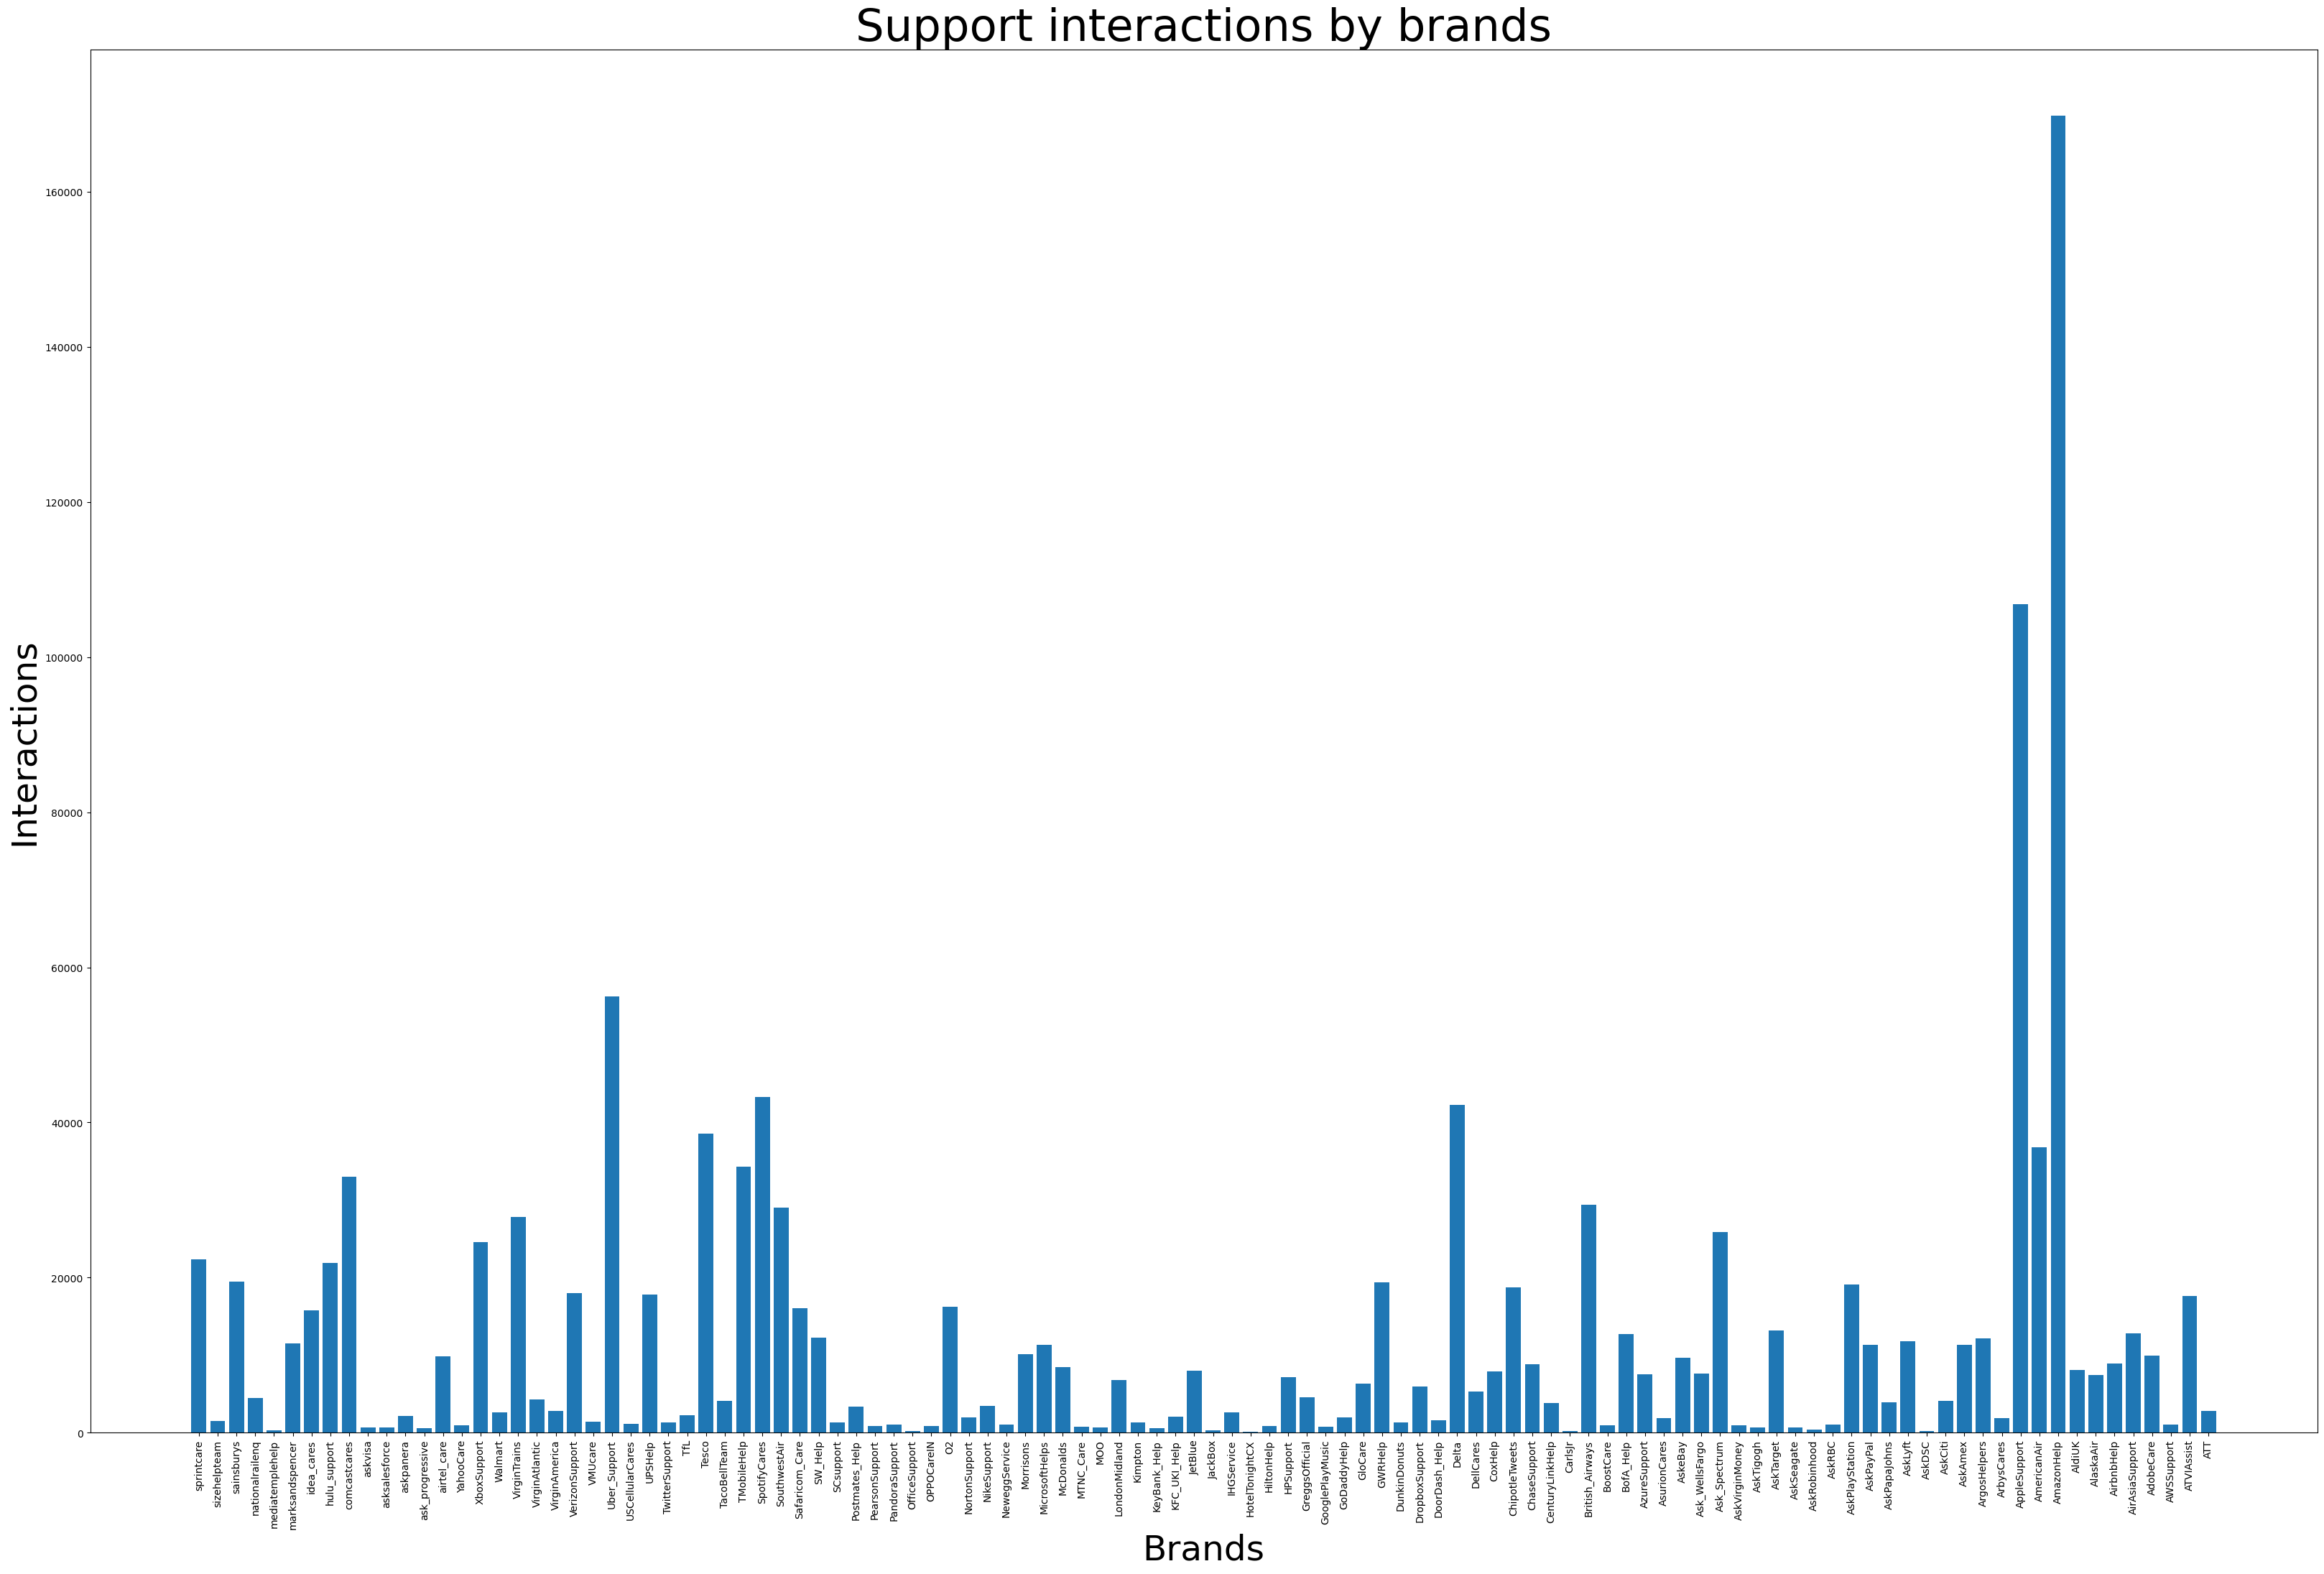

In [4]:
#let's take a look at the customer service interaction by a company

%matplotlib inline

plt.figure(figsize=(40,25))
plt.title('Support interactions by brands', fontsize=45)
plt.xlabel('Brands', fontsize =35)
plt.ylabel('Interactions', fontsize =35)
plt.bar(list(support_services.index.values),list(support_services.values))
plt.xticks(rotation=90)
plt.show()

In [5]:
#let's closely look at it for each company with more than 30k tweets

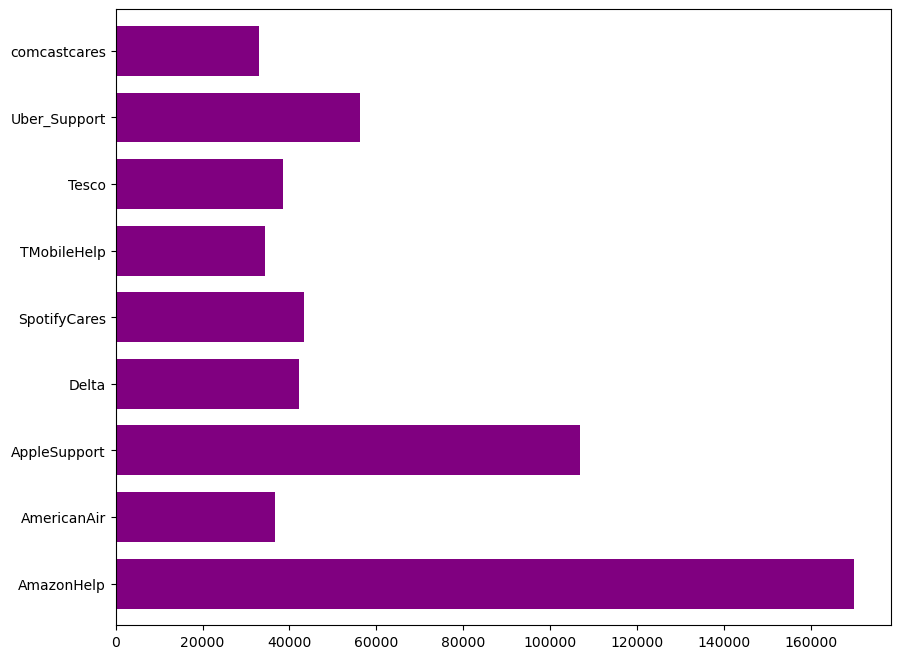

In [6]:
count = tweets.groupby("author_id")["text"].count()
c = count[count>30000].plot(kind='barh',figsize=(10, 8), color='purple', zorder=2, width=0.75)
c.set_ylabel('')
plt.show()

In [7]:
# largest number of customer support interaction was with Amazonsupport and the second high is Applesupport.
# Let's Choose AppleSupport for our project here

In [8]:
###Cleaning and Data processing

In [9]:
Apple_support = tweets[tweets['author_id']=='AppleSupport']

In [10]:
Apple_support.shape

(106860, 7)

In [11]:
#Now let's place every questions with their corresponding answer to closely look at the interactions

In [12]:
#define the three main columns for our analysis
Apple_support['interaction_tweet'] = ''
Apple_support['interaction_author'] = ''
Apple_support['interaction_tweet_at'] = ''

In [13]:
Apple_support.dropna(subset=['tweet_id', 'in_response_to_tweet_id'],inplace=True)
Apple_support.reset_index(drop=True,inplace=True)

In [14]:
for i in range(len(Apple_support)):
    Apple_support.at[i, 'interaction_tweet'] = str(list(tweets[tweets['tweet_id']==int(Apple_support.iloc[i]['in_response_to_tweet_id'])]['text'])).strip("[']")
    Apple_support.at[i, 'interaction_author'] = str(list(tweets[tweets['tweet_id']==int(Apple_support.iloc[i]['in_response_to_tweet_id'])]['author_id'])).strip("[']") 
    Apple_support.at[i, 'interaction_tweet_at'] = str(list(tweets[tweets['tweet_id']==int(Apple_support.iloc[i]['in_response_to_tweet_id'])]['created_at'])).strip("[']")

In [15]:
Apple_support.head(2)

,tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id,interaction_tweet,interaction_author,interaction_tweet_at
0,696,AppleSupport,False,Tue Oct 31 22:27:49 +0000 2017,@115854 We're here for you. Which version of t...,697,698.0,@AppleSupport https://t.co/NV0yucs0lB,115854,Tue Oct 31 22:17:40 +0000 2017
1,699,AppleSupport,False,Tue Oct 31 22:36:27 +0000 2017,@115854 Lets take a closer look into this issu...,NaN,697.0,@AppleSupport The newest update. I️ made sure ...,115854,Tue Oct 31 22:31:23 +0000 2017


In [16]:
#peeking into their interactions
Apple_support.iloc[1]['interaction_tweet']

'@AppleSupport The newest update. I️ made sure to download it yesterday.'

In [17]:
Apple_support.iloc[0]['text']

"@115854 We're here for you. Which version of the iOS are you running? Check from Settings &gt; General &gt; About."

In [18]:
Apple_support.dropna(subset=['interaction_tweet_at'],inplace=True)
Apple_support.shape

(106719, 10)

In [19]:
# that's a good sign i see some of the hyperlinks in the responses and some of the "&gt" signs could be just  arrow emoji's. We'll take a look into it later.
# First let's closely look into their daily interactions

In [20]:
days = Apple_support['interaction_tweet_at'].str.extractall(r'(^\w+)').values

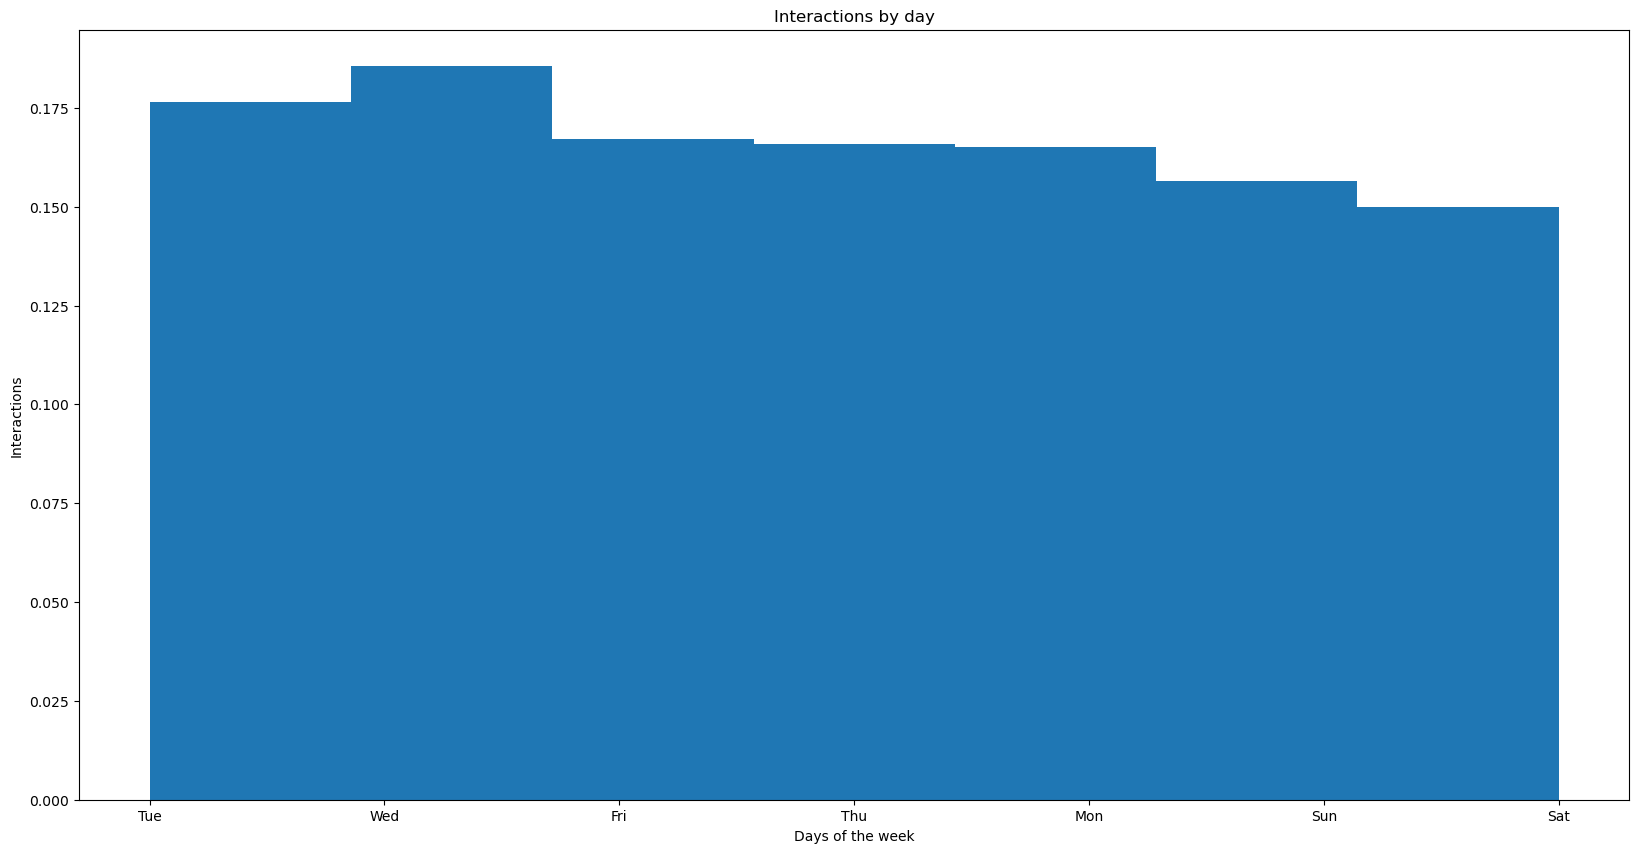

In [21]:
%matplotlib inline
plt.figure(figsize=(20,10))
plt.title('Interactions by day')
plt.xlabel('Days of the week')
plt.ylabel('Interactions')
plt.hist(days,bins=7,histtype='stepfilled',density=True)
plt.show()

In [22]:
## Applesupport is pretty busy throughout the week, Wednesdays are slightly more than other weekdays


In [23]:
time = Apple_support['interaction_tweet_at'].str.extractall(r'(\s\d{1,2}[:])').values
hours = []
for i in range(len(time)):
    hours.append(int(time[i][0].strip(' :')))

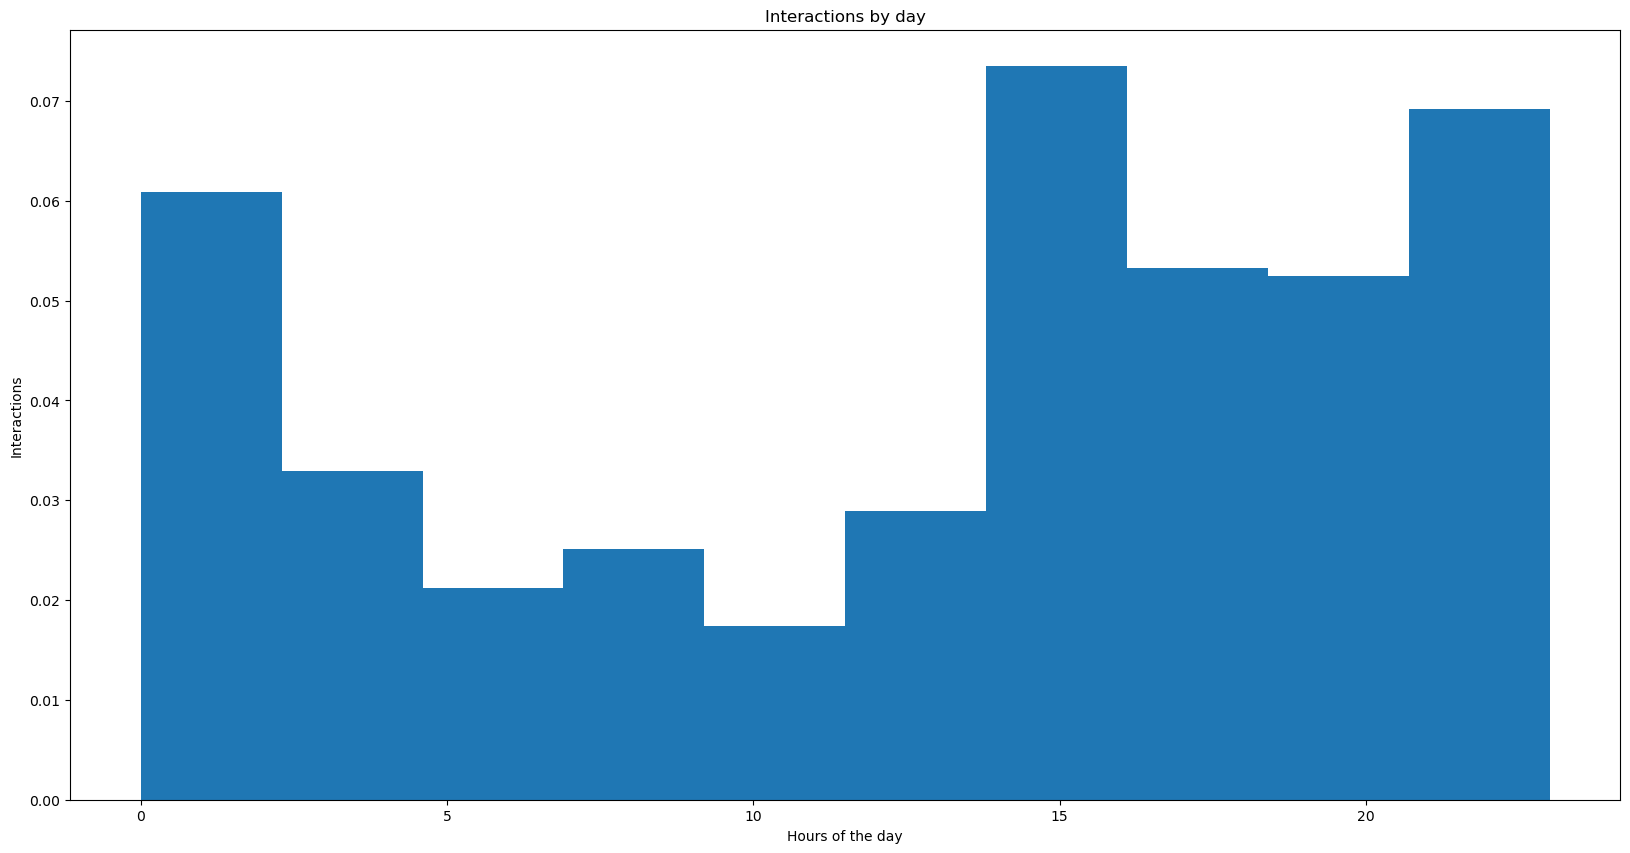

In [24]:
%matplotlib inline
plt.figure(figsize=(20,10))
plt.title('Interactions by day')
plt.xlabel('Hours of the day')
plt.ylabel('Interactions')
plt.hist(hours,histtype='stepfilled',density=True)
plt.show()

In [25]:
# and the above graph tells us their most busy hours are somewhere from 14 to midnight.
# Now let's take a look how long it takes them to respond to a single tweet?

In [26]:
Apple_support['Client interaction time'] = Apple_support['interaction_tweet_at'].str.extract(r'(\d{1,2}[:]\d{1,2}[:]\d{1,2})').values
Apple_support['Support interaction time'] = Apple_support['created_at'].str.extract(r'(\d{1,2}[:]\d{1,2}[:]\d{1,2})').values
Apple_support['TTR'] = np.nan

In [27]:
for i in range(len(Apple_support)):
    Apple_support.at[i, 'TTR'] = pd.Timestamp(Apple_support.iloc[i]['created_at']) - pd.Timestamp(Apple_support.iloc[i]['interaction_tweet_at'])

In [28]:
Apple_support.dropna(subset=['TTR'],inplace=True)
Apple_support.reset_index(drop=True,inplace=True)
str(Apple_support['TTR'].astype('timedelta64[s]').mean())

'0 days 02:27:21.519456529'

In [29]:
# so average it takes 2 hours and 27 minutes for apple support to reply.

In [30]:
str(Apple_support['TTR'].astype('timedelta64[s]').max())

'32 days 20:15:06'

In [31]:
## WOW! 32 days to reply to a tweet. Customer must be exhausted. Let's see

In [32]:
Apple_support.sort_values(by=['TTR'],ascending=False)[0:10]

,tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id,interaction_tweet,interaction_author,interaction_tweet_at,Client interaction time,Support interaction time,TTR
60087,1822477,AppleSupport,False,Sun Oct 15 18:14:38 +0000 2017,@400213 We'd like to look into the Maps issue ...,NaN,1822478.0,"Hey @115858, great announcement today. Meanwhi...",400213,Tue Sep 12 21:59:32 +0000 2017,21:59:32,18:14:38,32 days 20:15:06
18043,643265,AppleSupport,False,Mon Oct 23 14:01:02 +0000 2017,"@272718 Hey Tom, we'd like to take a closer lo...",NaN,643266.0,"#applemaps #siri says I\'m on the ""North J Tur...",272718,Sun Oct 08 20:59:06 +0000 2017,20:59:06,14:01:02,14 days 17:01:56
62531,1886971,AppleSupport,False,Mon Oct 23 13:49:36 +0000 2017,"@562799 Hey Teri, we'd like to look into this ...",NaN,1886972.0,My Apple Maps voice keeps saying “U S Forest…”...,562799,Mon Oct 09 20:55:39 +0000 2017,20:55:39,13:49:36,13 days 16:53:57
8614,330883,AppleSupport,False,Sun Sep 17 20:14:30 +0000 2017,Ready to update to #iOS11 on Tuesday? \n\nFoll...,"330884,330885,330886,330887",330888.0,#iOS11 is arriving on September 19\n\nCheck he...,AppleSupport,Tue Sep 12 19:21:09 +0000 2017,19:21:09,20:14:30,5 days 00:53:21
33785,1187136,AppleSupport,False,Tue Oct 24 23:49:00 +0000 2017,@399153 We'd like to help if you can let us kn...,NaN,1187137.0,Did you support The God Box by David Banner? ...,399153,Fri Oct 20 12:39:18 +0000 2017,12:39:18,23:49:00,4 days 11:09:42
11930,445987,AppleSupport,False,Thu Nov 30 18:49:24 +0000 2017,"@220623 Hello Kate, we'd like to look into thi...",NaN,445988.0,"Apple maps is ""saving"" us 44 minutes due to tr...",220623,Sun Nov 26 19:36:11 +0000 2017,19:36:11,18:49:24,3 days 23:13:13
85764,2322528,AppleSupport,False,Mon Nov 13 14:33:26 +0000 2017,@672986 We'd like to check this out with you. ...,NaN,2322529.0,@115858 your maps app is trying to have me dr...,672986,Thu Nov 09 18:57:57 +0000 2017,18:57:57,14:33:26,3 days 19:35:29
86583,2353692,AppleSupport,False,Mon Nov 13 18:33:30 +0000 2017,"@680107 Hello Scott, we hope you had a great w...",NaN,2353693.0,"""Fourth time my Touchbar MBP has frozen today ...",680107,Fri Nov 10 05:31:44 +0000 2017,05:31:44,18:33:30,3 days 13:01:46
31694,1131395,AppleSupport,False,Tue Oct 24 12:10:24 +0000 2017,@212696 We can help with your device. Let us k...,NaN,1131396.0,@AppleSupport is there a way to fix my phone t...,212696,Sat Oct 21 00:54:23 +0000 2017,00:54:23,12:10:24,3 days 11:16:01
50542,1477620,AppleSupport,False,Mon Nov 06 03:35:35 +0000 2017,@463097 We'd like to learn more about this. Pl...,NaN,1477619.0,Defect found in the first #iPhoneX here. Scree...,463097,Thu Nov 02 20:59:32 +0000 2017,20:59:32,03:35:35,3 days 06:36:03


In [33]:
print(Apple_support.iloc[60087]['interaction_tweet'])
print(Apple_support.iloc[18043]['interaction_tweet'])
print(Apple_support.iloc[62531]['interaction_tweet'])
print(Apple_support.iloc[8614]['interaction_tweet'])
print(Apple_support.iloc[33785]['interaction_tweet'])
print(Apple_support.iloc[11930]['interaction_tweet'])
print(Apple_support.iloc[85764]['interaction_tweet'])
print(Apple_support.iloc[86583]['interaction_tweet'])
print(Apple_support.iloc[31694]['interaction_tweet'])
print(Apple_support.iloc[50542]['interaction_tweet'])

Hey @115858, great announcement today. Meanwhile your product quality gets worse. Podcast app needs constant babysitting. #FixYourStuffApple
#applemaps #siri says I\'m on the "North J Turnpike" Oof. https://t.co/34fo5j7nX8
My Apple Maps voice keeps saying “U S Forest…” instead of “USF” for aml of the street names on campus. 😀
#iOS11 is arriving on September 19\n\nCheck here to see if your device is compatible https://t.co/4jSsgPELOH
Did you support The God Box by David Banner?  https://t.co/UbXXdHP0jQ
Apple maps is "saving" us 44 minutes due to traffic by sending us on a winding 1 lane gravel mountain road. Behind a Winnebago. 😱
@115858  your maps app is trying to have me drive into oncoming traffic.... https://t.co/ILc0YrVXyX
"Fourth time my Touchbar MBP has frozen today - mouse moves but that's it, have to hard power restart. At least 1x per day, sometimes 10. Several coworkers with new MBPs same thing. Is this just a thing with new Apple hardware now?"
@AppleSupport is there a way t

In [34]:
##seems like apple takes longer time to reply on these issues.
#Let's get in detail on these customer tweets and see what words are being used mostly. 

In [35]:
###Normalizing the Data

In [36]:
# converting to lower case

In [37]:
Apple_support["interaction_tweet"] = Apple_support["interaction_tweet"].str.lower()
Apple_support.head()

,tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id,interaction_tweet,interaction_author,interaction_tweet_at,Client interaction time,Support interaction time,TTR
0,696,AppleSupport,False,Tue Oct 31 22:27:49 +0000 2017,@115854 We're here for you. Which version of t...,697,698.0,@applesupport https://t.co/nv0yucs0lb,115854,Tue Oct 31 22:17:40 +0000 2017,22:17:40,22:27:49,0 days 00:10:09
1,699,AppleSupport,False,Tue Oct 31 22:36:27 +0000 2017,@115854 Lets take a closer look into this issu...,NaN,697.0,@applesupport the newest update. i️ made sure ...,115854,Tue Oct 31 22:31:23 +0000 2017,22:31:23,22:36:27,0 days 00:05:04
2,701,AppleSupport,False,Tue Oct 31 22:26:49 +0000 2017,@115855 Let's go to DM for the next steps. DM ...,NaN,702.0,@applesupport tried resetting my settings .. r...,115855,Tue Oct 31 22:11:31 +0000 2017,22:11:31,22:26:49,0 days 00:15:18
3,703,AppleSupport,False,Tue Oct 31 22:09:52 +0000 2017,@115855 Any steps tried since it started last ...,702,704.0,@applesupport this is what it looks like https...,115855,Tue Oct 31 21:59:17 +0000 2017,21:59:17,22:09:52,0 days 00:10:35
4,705,AppleSupport,False,Tue Oct 31 21:57:00 +0000 2017,@115855 That's great it has iOS 11.1 as we can...,"706,704",707.0,@applesupport i️ have an iphone 7 plus and yes...,115855,Tue Oct 31 21:48:51 +0000 2017,21:48:51,21:57:00,0 days 00:08:09


In [38]:
AppleSupport_df = Apple_support.to_csv("/Users/kamininayyar/Downloads/Apple_support.csv", index=False)

In [39]:
# Removing Stopwords

In [40]:
", ".join(stopwords.words('english'))

"i, me, my, myself, we, our, ours, ourselves, you, you're, you've, you'll, you'd, your, yours, yourself, yourselves, he, him, his, himself, she, she's, her, hers, herself, it, it's, its, itself, they, them, their, theirs, themselves, what, which, who, whom, this, that, that'll, these, those, am, is, are, was, were, be, been, being, have, has, had, having, do, does, did, doing, a, an, the, and, but, if, or, because, as, until, while, of, at, by, for, with, about, against, between, into, through, during, before, after, above, below, to, from, up, down, in, out, on, off, over, under, again, further, then, once, here, there, when, where, why, how, all, any, both, each, few, more, most, other, some, such, no, nor, not, only, own, same, so, than, too, very, s, t, can, will, just, don, don't, should, should've, now, d, ll, m, o, re, ve, y, ain, aren, aren't, couldn, couldn't, didn, didn't, doesn, doesn't, hadn, hadn't, hasn, hasn't, haven, haven't, isn, isn't, ma, mightn, mightn't, mustn, mus

In [41]:
for i in range(len(Apple_support)):
    Apple_support.at[i,'interaction_tweet'] = Apple_support.loc[i]['interaction_tweet'].replace('"','')

In [42]:
stops = set(stopwords.words('english'))
def remove_stops(corpus):
    return " ".join([word for word in str(corpus).split() if word not in stops])
Apple_support["interaction_tweet"] = Apple_support["interaction_tweet"].apply(lambda text: remove_stops(text))
Apple_support.head()

,tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id,interaction_tweet,interaction_author,interaction_tweet_at,Client interaction time,Support interaction time,TTR
0,696,AppleSupport,False,Tue Oct 31 22:27:49 +0000 2017,@115854 We're here for you. Which version of t...,697,698.0,@applesupport https://t.co/nv0yucs0lb,115854,Tue Oct 31 22:17:40 +0000 2017,22:17:40,22:27:49,0 days 00:10:09
1,699,AppleSupport,False,Tue Oct 31 22:36:27 +0000 2017,@115854 Lets take a closer look into this issu...,NaN,697.0,@applesupport newest update. i️ made sure down...,115854,Tue Oct 31 22:31:23 +0000 2017,22:31:23,22:36:27,0 days 00:05:04
2,701,AppleSupport,False,Tue Oct 31 22:26:49 +0000 2017,@115855 Let's go to DM for the next steps. DM ...,NaN,702.0,@applesupport tried resetting settings .. rest...,115855,Tue Oct 31 22:11:31 +0000 2017,22:11:31,22:26:49,0 days 00:15:18
3,703,AppleSupport,False,Tue Oct 31 22:09:52 +0000 2017,@115855 Any steps tried since it started last ...,702,704.0,@applesupport looks like https://t.co/xcqu2l4xub,115855,Tue Oct 31 21:59:17 +0000 2017,21:59:17,22:09:52,0 days 00:10:35
4,705,AppleSupport,False,Tue Oct 31 21:57:00 +0000 2017,@115855 That's great it has iOS 11.1 as we can...,"706,704",707.0,@applesupport i️ iphone 7 plus yes i️,115855,Tue Oct 31 21:48:51 +0000 2017,21:48:51,21:57:00,0 days 00:08:09


In [43]:
# Let's remove punctuation

In [44]:
punctuation_signs = string.punctuation
def remove_punctuation_signs(corpus):
    return corpus.translate(str.maketrans('', '', punctuation_signs))

Apple_support["interaction_tweet"] = Apple_support["interaction_tweet"].apply(lambda corpus: remove_punctuation_signs(corpus))
Apple_support.head()

,tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id,interaction_tweet,interaction_author,interaction_tweet_at,Client interaction time,Support interaction time,TTR
0,696,AppleSupport,False,Tue Oct 31 22:27:49 +0000 2017,@115854 We're here for you. Which version of t...,697,698.0,applesupport httpstconv0yucs0lb,115854,Tue Oct 31 22:17:40 +0000 2017,22:17:40,22:27:49,0 days 00:10:09
1,699,AppleSupport,False,Tue Oct 31 22:36:27 +0000 2017,@115854 Lets take a closer look into this issu...,NaN,697.0,applesupport newest update i️ made sure downlo...,115854,Tue Oct 31 22:31:23 +0000 2017,22:31:23,22:36:27,0 days 00:05:04
2,701,AppleSupport,False,Tue Oct 31 22:26:49 +0000 2017,@115855 Let's go to DM for the next steps. DM ...,NaN,702.0,applesupport tried resetting settings restart...,115855,Tue Oct 31 22:11:31 +0000 2017,22:11:31,22:26:49,0 days 00:15:18
3,703,AppleSupport,False,Tue Oct 31 22:09:52 +0000 2017,@115855 Any steps tried since it started last ...,702,704.0,applesupport looks like httpstcoxcqu2l4xub,115855,Tue Oct 31 21:59:17 +0000 2017,21:59:17,22:09:52,0 days 00:10:35
4,705,AppleSupport,False,Tue Oct 31 21:57:00 +0000 2017,@115855 That's great it has iOS 11.1 as we can...,"706,704",707.0,applesupport i️ iphone 7 plus yes i️,115855,Tue Oct 31 21:48:51 +0000 2017,21:48:51,21:57:00,0 days 00:08:09


In [45]:
# Now let's remove applesupport from every tweet

In [46]:
for i in range(len(Apple_support)):
    Apple_support.at[i,'interaction_tweet'] = Apple_support.loc[i]['interaction_tweet'].replace('applesupport','')
Apple_support.head()

,tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id,interaction_tweet,interaction_author,interaction_tweet_at,Client interaction time,Support interaction time,TTR
0,696,AppleSupport,False,Tue Oct 31 22:27:49 +0000 2017,@115854 We're here for you. Which version of t...,697,698.0,httpstconv0yucs0lb,115854,Tue Oct 31 22:17:40 +0000 2017,22:17:40,22:27:49,0 days 00:10:09
1,699,AppleSupport,False,Tue Oct 31 22:36:27 +0000 2017,@115854 Lets take a closer look into this issu...,NaN,697.0,newest update i️ made sure download yesterday,115854,Tue Oct 31 22:31:23 +0000 2017,22:31:23,22:36:27,0 days 00:05:04
2,701,AppleSupport,False,Tue Oct 31 22:26:49 +0000 2017,@115855 Let's go to DM for the next steps. DM ...,NaN,702.0,tried resetting settings restarting phone,115855,Tue Oct 31 22:11:31 +0000 2017,22:11:31,22:26:49,0 days 00:15:18
3,703,AppleSupport,False,Tue Oct 31 22:09:52 +0000 2017,@115855 Any steps tried since it started last ...,702,704.0,looks like httpstcoxcqu2l4xub,115855,Tue Oct 31 21:59:17 +0000 2017,21:59:17,22:09:52,0 days 00:10:35
4,705,AppleSupport,False,Tue Oct 31 21:57:00 +0000 2017,@115855 That's great it has iOS 11.1 as we can...,"706,704",707.0,i️ iphone 7 plus yes i️,115855,Tue Oct 31 21:48:51 +0000 2017,21:48:51,21:57:00,0 days 00:08:09


In [50]:
cleaning_df = Apple_support.to_csv("/Users/kamininayyar/Downloads/half_cleaned_Apple_support.csv", index=False)